In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

E0000 00:00:1728085404.186325      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D1004 23:43:24.194408429      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1004 23:43:24.194423721      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1004 23:43:24.194427052      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1004 23:43:24.194429435      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1004 23:43:24.194431748      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

In [2]:
# Load the dataset
data = np.load('/kaggle/input/512gender2/Page2_1024_512_full.npz')
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']

# Reshape the images (from flat to original size)
X_train = X_train.reshape((-1, 512, 1024, 1))  # Grayscale
X_test = X_test.reshape((-1, 512, 1024, 1))

# Convert grayscale to 3 channels by repeating the single channel
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Normalize pixel values (0-255) to range (0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

In [3]:
import tensorflow as tf

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

# Create a strategy for distributed training
#strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1728085510.567063      13 service.cc:145] XLA service 0x5b2a350548e0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728085510.567129      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1728085510.567133      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1728085510.567136      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1728085510.567139      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1728085510.567144      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1728085510.567147      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1728085510.567150      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1728085510.567152      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [4]:
with tpu_strategy.scope():
    # Define the base model with ImageNet weights, without the top layers
    base_model = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=(512, 1024, 3))

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers on top of the base model
    inputs = Input(shape=(512, 1024, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)  # Global average pooling layer
    x = Dense(128, activation='relu')(x)  # Custom dense layer
    outputs = Dense(2, activation='softmax')(x)  # Output layer for 2 classes

    # Create the final model
    model = Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    

model.summary()

I0000 00:00:1728085514.729596      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 1024, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-m (Functional)   │ (None, 16, 32, 1280)   │    53,150,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,314,614 (203.38 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 53,150,388 (202.75 MB)

In [5]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,  # You can increase epochs based on performance
                    batch_size=16,
                    callbacks=[early_stopping])

# Save the model in .keras format
model.save('AP-EfficientNetV2M_Model_1024Gender_Trained.keras')

Epoch 1/100


2024-10-04 23:48:32.840437: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1728085716.010466     820 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ba5c6138630b992c:0:0), session_name()
I0000 00:00:1728085815.531775     820 tpu_compile_op_common.cc:245] Compilation of ba5c6138630b992c:0:0 with session name  took 1m39.521249758s and succeeded
I0000 00:00:1728085815.804632     820 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ba5c6138630b992c:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_5826884984169653308", property.function_library_fingerprint = 7591286473176259698, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z

445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4994 - loss: 0.6922

2024-10-04 23:51:35.361748: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
I0000 00:00:1728085897.223073     823 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(9829a9a5285138ce:0:0), session_name()
I0000 00:00:1728085910.588312     823 tpu_compile_op_common.cc:245] Compilation of 9829a9a5285138ce:0:0 with session name  took 13.365180572s and succeeded
I0000 00:00:1728085910.631346     823 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(9829a9a5285138ce:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_5524695471453262861", property.function_library_fingerprint = 2901011394350656654, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, t

445/445 ━━━━━━━━━━━━━━━━━━━━ 226s 239ms/step - accuracy: 0.4995 - loss: 0.6922 - val_accuracy: 0.5022 - val_loss: 0.6969
Epoch 2/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 54s 121ms/step - accuracy: 0.5288 - loss: 0.6923 - val_accuracy: 0.5471 - val_loss: 0.6932
Epoch 3/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - accuracy: 0.4773 - loss: 0.6954 - val_accuracy: 0.4978 - val_loss: 0.6986
Epoch 4/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - accuracy: 0.4729 - loss: 0.6940 - val_accuracy: 0.4978 - val_loss: 0.6961
Epoch 5/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - accuracy: 0.4774 - loss: 0.6985 - val_accuracy: 0.5022 - val_loss: 0.6931
Epoch 6/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - accuracy: 0.5009 - loss: 0.6937 - val_accuracy: 0.4978 - val_loss: 0.6996
Epoch 7/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - accuracy: 0.4968 - loss: 0.6935 - val_accuracy: 0.4933 - val_loss: 0.6935
Epoch 8/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - accuracy: 0.4528 - loss: 0.69

ValueError: Device /job:localhost/replica:0/task:0/device:CPU:0 is not found

In [6]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

I0000 00:00:1728086588.774680     767 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(f56d06c7e967c76b:0:0), session_name()


 1/56 ━━━━━━━━━━━━━━━━━━━━ 12:51 14s/step - accuracy: 0.7500 - loss: 0.6919

I0000 00:00:1728086601.864359     767 tpu_compile_op_common.cc:245] Compilation of f56d06c7e967c76b:0:0 with session name  took 13.089616644s and succeeded
I0000 00:00:1728086601.894313     767 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(f56d06c7e967c76b:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_5524695471453262861", property.function_library_fingerprint = 2901011394350656654, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,512,1024,3,;4,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728086601.894351     767 tpu_compilation_cache_interface.cc:541] After adding entry for key 

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5391 - loss: 0.6933

I0000 00:00:1728086609.647362     813 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(79a7b9f932b534e6:0:0), session_name()


56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 369ms/step - accuracy: 0.5400 - loss: 0.6933


I0000 00:00:1728086622.159779     813 tpu_compile_op_common.cc:245] Compilation of 79a7b9f932b534e6:0:0 with session name  took 12.512377165s and succeeded
I0000 00:00:1728086622.190727     813 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(79a7b9f932b534e6:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_5524695471453262861", property.function_library_fingerprint = 2901011394350656654, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,1024,3,;3,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728086622.190771     813 tpu_compilation_cache_interface.cc:541] After adding entry for key 

Test accuracy: 56.50%


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow.keras.optimizers as optimizers
import matplotlib.pyplot as plt

# Get the default learning rate for the Adam optimizer
d_learning_rate = optimizers.Adam().get_config()['learning_rate']

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics calculation
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Additional information
print("Number of Epochs:", len(history.history['accuracy']))
print("Size of Image:", X_train.shape[1:])
print("Learning Rate: ",d_learning_rate)

2024-10-05 00:04:22.952363: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/dense_1/Add/ReadVariableOp.
I0000 00:00:1728086664.455085     788 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(bc289160ee6c819c:0:0), session_name()


 1/56 ━━━━━━━━━━━━━━━━━━━━ 18:21 20s/step

I0000 00:00:1728086674.843642     788 tpu_compile_op_common.cc:245] Compilation of bc289160ee6c819c:0:0 with session name  took 10.388506723s and succeeded
I0000 00:00:1728086674.873796     788 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(bc289160ee6c819c:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_10391334958381856265", property.function_library_fingerprint = 17329504422517333462, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728086674.873845     788 tpu_compilation_cache_interface.cc:541] After adding entry for key bc289160e

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step

I0000 00:00:1728086702.830164     832 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(42c3a1757837e21e:0:0), session_name()


56/56 ━━━━━━━━━━━━━━━━━━━━ 60s 724ms/step


I0000 00:00:1728086714.634594     832 tpu_compile_op_common.cc:245] Compilation of 42c3a1757837e21e:0:0 with session name  took 11.804387433s and succeeded
I0000 00:00:1728086714.669069     832 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(42c3a1757837e21e:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_17272892181780323400", property.function_library_fingerprint = 15068038840331830492, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,1024,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728086714.669110     832 tpu_compilation_cache_interface.cc:541] After adding entry for

Accuracy: 0.49775280898876406
Precision: 0.49778088964825296
Recall: 0.4977913114396054
F1 Score: 0.4971814964610718
Number of Epochs: 12
Size of Image: (512, 1024, 3)
Learning Rate:  0.0010000000474974513


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step


<Figure size 1600x1600 with 0 Axes>

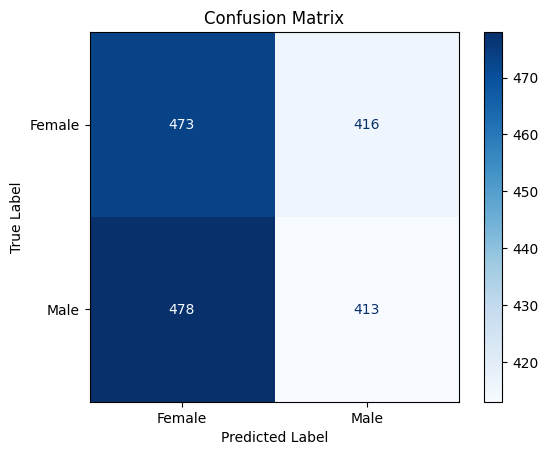

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model and get predictions
y_pred = model.predict(X_test)

# Convert the predictions from one-hot encoded to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
labels = ['Female', 'Male']  # Adjust according to your labels

plt.figure(figsize=(16, 16))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

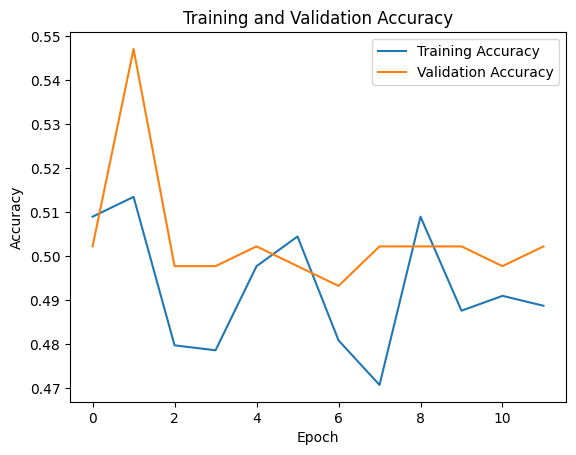

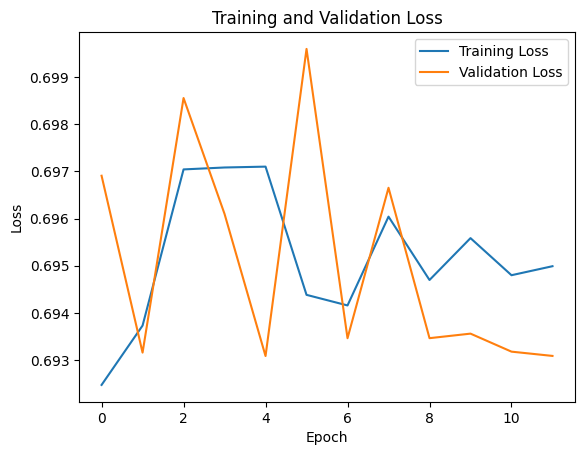

In [9]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()